# Clustered CART Model (XGBoost)

## 1. Explanation of Model

In a nutshell, this model runs XGBoost. Over and over and over and over again.

The approach of this model is this:

1) Get mosquito clusters via unsupervised learning strategies like DBScan/KMeans/Meanshift. This is trained on latitude, longitude, and number of mosquitos.

2) Use existing features to predict number of mosquitos in Kaggle set (since this data doesn't exist in that set)

3) Train a KNN model on the Latitude, Longitude, and NumMosquitos on the train set, and fit it onto the Kaggle model to get the class labels associated with a specific cluster.

4) XGBClassifier is then run on the main feature set with the clusters encoded into dummy variables.

5) Entire process is repeated for Combined set, 2007 only, 2009 only, 2011 only, and 2013 only, and bagged together with weights to deliver a final output.

In [1]:
#General Imports
import pandas as pd
import numpy as np
import time
import random
import math
from collections import namedtuple, Counter
import scipy.stats as stats
from scipy.stats import norm
import datetime
from haversine import haversine, Unit

#Plotting/Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

%matplotlib inline

#Modelling Imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

#Lets you view all columns in a dataframe when there are a LARGE number of columns
pd.set_option('display.max_columns', None)
#Fix for pandas truncating long strings (e.g. urls)
#If you don't run this, pandas will cut short your long urls and this breaks code that require urls
pd.set_option("display.max_colwidth", 10000)

In [6]:
df_combined = pd.read_csv(r'./datasets/clean_train_1.csv')
df_kag = pd.read_csv(r'./datasets/clean_test_1.csv')

In [21]:
df_combined.drop('Unnamed: 0', axis = 1, inplace = True)
df_kag.drop('Unnamed: 0', axis = 1, inplace = True)

## 2. Tuning Clusters

In [7]:
def geo_cluster_model(model, model_name, dataframe, features = ['Latitude', 'Longitude']):
    model.fit(dataframe[features])
    dataframe[model_name+'_clusters'] = model.labels_
    print('Number of classes: {}'.format(len(set(model.labels_))))
    print('Silhouette Score: {}'.format(silhouette_score(dataframe[features], model.labels_)))
    sns.lmplot(x = 'Latitude', y= 'Longitude', data = dataframe, fit_reg = False, hue = model_name+'_clusters', height = 15)
    return dataframe.groupby([model_name+'_clusters'])[['NumMosquitos', 'WnvPresent']].agg(['mean', 'count'])

Number of classes: 105
Silhouette Score: 0.9442561695903843


NumMosquitos       WnvPresent      
                             mean count       mean count
dbscan_geog_clusters                                    
-1                       6.000000     3   0.000000     3
 0                      11.678788   165   0.030303   165
 1                       5.058824   102   0.009804   102
 2                       4.673797   187   0.005348   187
 3                       7.311828    93   0.053763    93
 4                       8.990000   100   0.070000   100
 5                       8.141026    78   0.064103    78
 6                       9.386207   145   0.027586   145
 7                       6.100000    80   0.037500    80
 8                       4.466667    15   0.000000    15
 9                       8.970149   134   0.044776   134
 10                     31.951220    41   0.170732    41
 11                     13.619048    42   0.119048    42
 12                      4.297872    94   0.021277    94
 13                      4.989796    98   0.040816    98
 14                     21.280992   121   0.041322   121
 15                      3.647059    51   0.000000    51
 16                     21.238095   147   0.054422   147
 17                     11.100719   139   0.035971   139
 18                      8.689189   222   0.040541   222
 19                      3.500000    20   0.050000    20
 20                     12.481481   135   0.051852   135
 21                     10.113208    53   0.075472    53
 22                      2.545455    22   0.000000    22
 23                     10.488000   125   0.088000   125
 24                      7.331034   145   0.055172   145
 25                      3.095745    94   0.010638    94
 26                     25.572414   145   0.103448   145
 27                      6.712766    94   0.042553    94
 28                      3.000000    24   0.000000    24
...                           ...   ...        ...   ...
 74                      4.350649    77   0.012987    77
 75                      5.255556    90   0.044444    90
 76                      6.691919   198   0.020202   198
 77                      4.941176    68   0.029412    68
 78                     10.653465   101   0.039604   101
 79                     22.238710   155   0.038710   155
 80                      5.893204   103   0.019417   103
 81                      7.906040   149   0.020134   149
 82                    151.524476   143   0.104895   143
 83                     66.370861   151   0.072848   151
 84                     13.680000   100   0.010000   100
 85                     27.857143   119   0.058824   119
 86                      2.944444    18   0.000000    18
 87                      2.833333     6   0.000000     6
 88                      3.066667    45   0.000000    45
 89                     10.863636    22   0.000000    22
 90                      8.600000    15   0.066667    15
 91                     93.375000    32   0.125000    32
 92                      7.400000    90   0.077778    90
 93                     18.467391    92   0.076087    92
 94                     21.405797    69   0.072464    69
 95                     99.909091   154   0.188312   154
 96                     24.239583    96   0.093750    96
 97                     23.976190    84   0.130952    84
 98                     16.842857    70   0.057143    70
 99                     17.080000    75   0.120000    75
 100                     5.259259    54   0.018519    54
 101                    11.306667    75   0.053333    75
 102                     3.500000     8   0.000000     8
 103                     9.131148    61   0.114754    61

[105 rows x 4 columns]

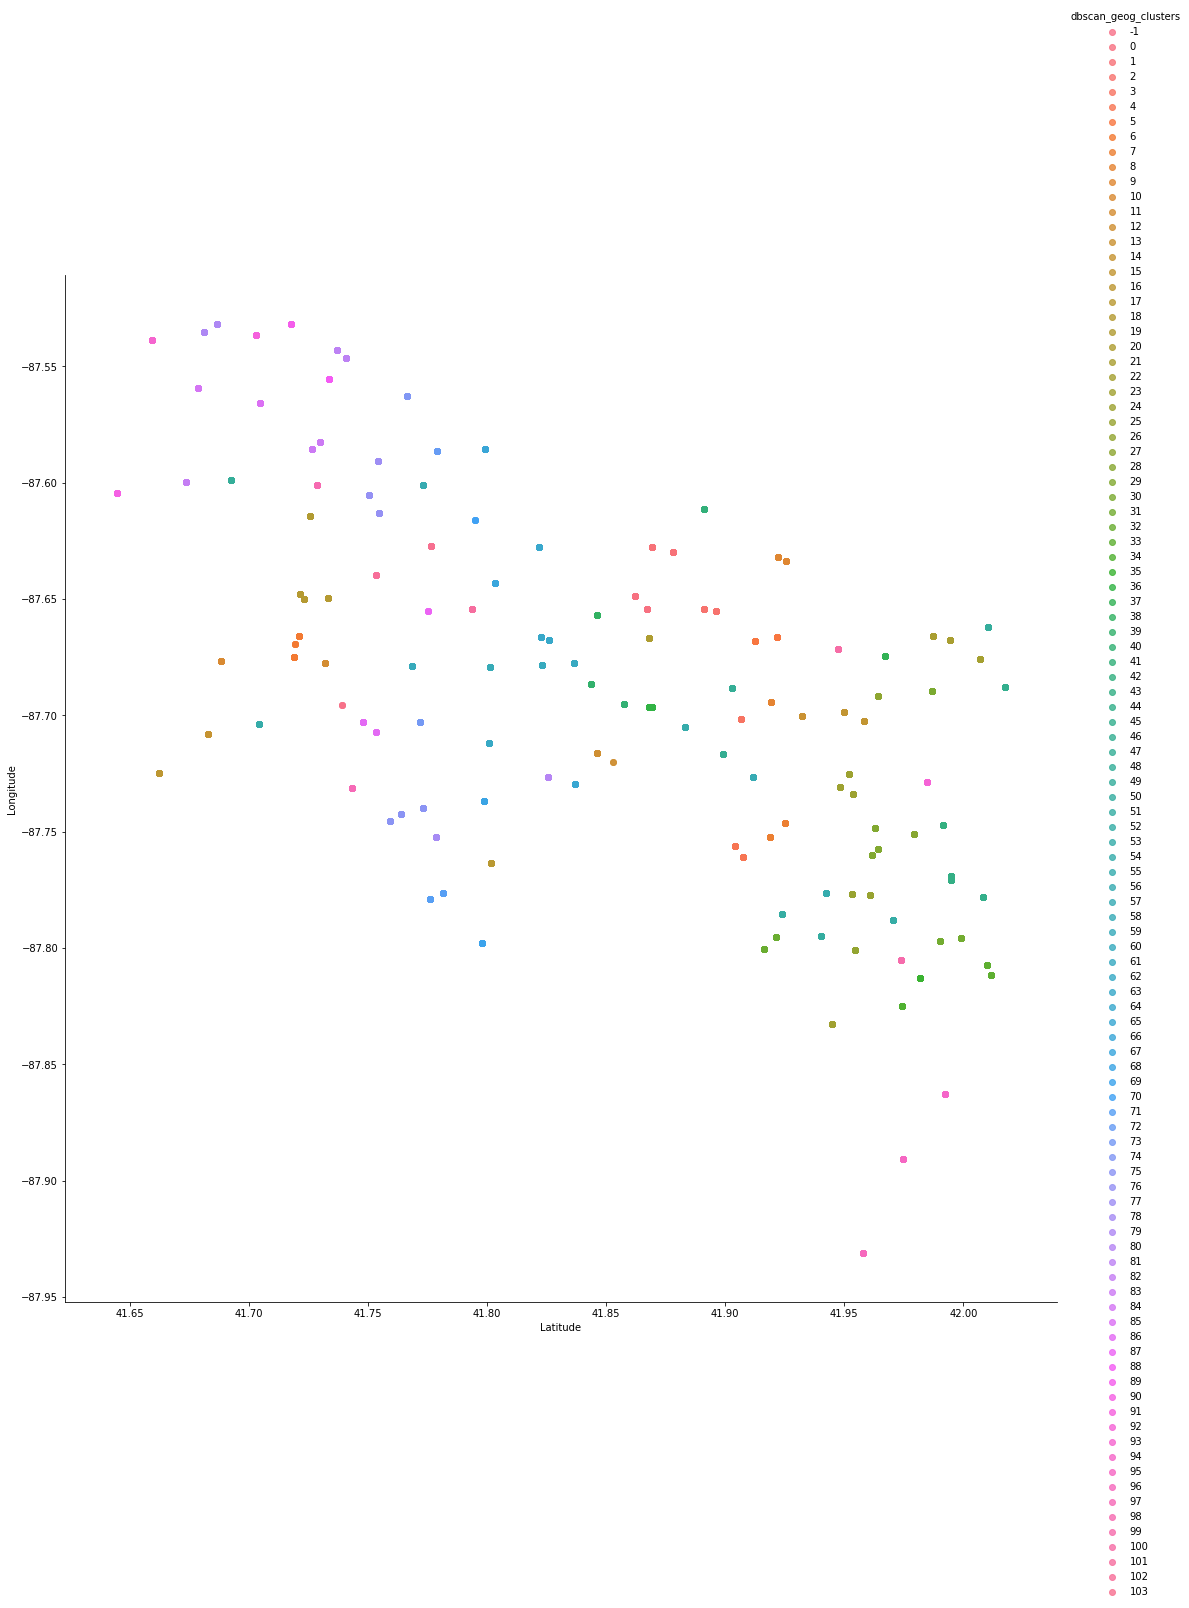

In [8]:
geo_cluster_model(DBSCAN(eps = 0.01, min_samples = 5, n_jobs= -1, algorithm = 'brute'), 'dbscan_geog', df_combined,
                 features = ['Latitude', 'Longitude'])

Number of classes: 66
Silhouette Score: 0.7851844423340677


NumMosquitos       WnvPresent      
                             mean count       mean count
dbscan_mosq_clusters                                    
-1                     224.046358   302   0.298013   302
 0                       2.000000  1167   0.005141  1167
 1                       1.000000  2096   0.008111  2096
 2                       3.000000   801   0.014981   801
 3                       4.000000   539   0.022263   539
 4                       8.000000   210   0.047619   210
 5                       7.000000   302   0.029801   302
 6                       5.000000   431   0.039443   431
 7                       9.000000   206   0.072816   206
 8                      10.000000   178   0.056180   178
 9                       6.000000   365   0.027397   365
 10                     20.000000    63   0.126984    63
 11                     25.000000    37   0.108108    37
 12                     19.000000    63   0.047619    63
 13                     16.000000   104   0.115385   104
 14                     28.000000    30   0.233333    30
 15                     12.000000   108   0.092593   108
 16                     11.000000   147   0.054422   147
 17                     15.000000    95   0.105263    95
 18                     14.000000    96   0.062500    96
 19                     22.000000    43   0.116279    43
 20                     21.000000    59   0.118644    59
 21                     29.000000    24   0.125000    24
 22                     27.000000    38   0.157895    38
 23                     18.000000    70   0.128571    70
 24                     17.000000    74   0.094595    74
 25                     13.000000   140   0.128571   140
 26                     39.000000    20   0.250000    20
 27                     51.000000    10   0.100000    10
 28                     34.000000    17   0.176471    17
...                           ...   ...        ...   ...
 35                     55.000000    12   0.166667    12
 36                     23.000000    50   0.180000    50
 37                     24.000000    50   0.120000    50
 38                     36.000000    24   0.125000    24
 39                     69.000000    11   0.454545    11
 40                     41.000000    16   0.250000    16
 41                     67.000000    10   0.300000    10
 42                     52.000000     9   0.222222     9
 43                     46.000000    13   0.153846    13
 44                     31.000000    27   0.222222    27
 45                     43.000000    15   0.266667    15
 46                     61.000000     8   0.250000     8
 47                     35.000000    22   0.181818    22
 48                     33.000000    19   0.210526    19
 49                     45.000000    16   0.312500    16
 50                     44.000000    13   0.076923    13
 51                     70.000000     6   0.333333     6
 52                     37.000000    33   0.212121    33
 53                     79.000000     6   0.333333     6
 54                     63.000000     8   0.250000     8
 55                     49.000000     9   0.111111     9
 56                     38.000000    22   0.318182    22
 57                    118.000000     5   0.200000     5
 58                     57.000000     6   0.166667     6
 59                     40.000000    19   0.210526    19
 60                     48.000000     8   0.125000     8
 61                     47.000000    19   0.315789    19
 62                     58.000000     7   0.285714     7
 63                     54.000000    12   0.416667    12
 64                     59.000000     6   0.166667     6

[66 rows x 4 columns]

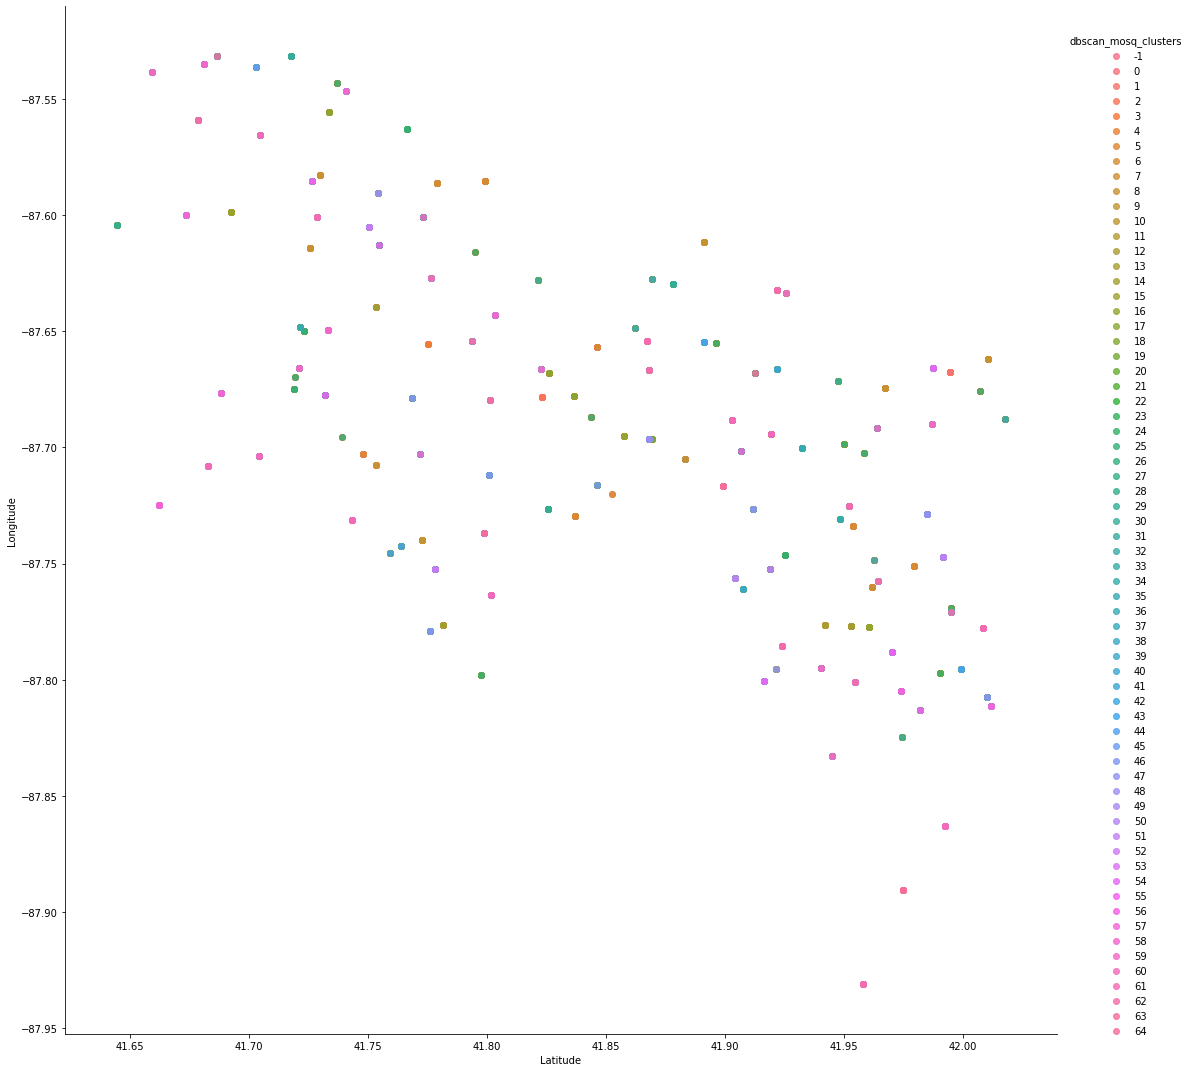

In [9]:
geo_cluster_model(DBSCAN(eps = 0.2, min_samples = 5, n_jobs= -1, algorithm = 'brute'), 'dbscan_mosq', df_combined,
                 features = ['Latitude', 'Longitude', 'NumMosquitos'])

Number of classes: 75
Silhouette Score: 0.8660377821067502


kmeans_geog_clusters NumMosquitos       WnvPresent      
                                mean count       mean count
0                     0     3.181818    66   0.000000    66
1                     1    11.182540   126   0.047619   126
2                     2    66.370861   151   0.072848   151
3                     3     4.920354   113   0.035398   113
4                     4    99.909091   154   0.188312   154
5                     5    25.572414   145   0.103448   145
6                     6     6.433333   210   0.014286   210
7                     7    21.238095   147   0.054422   147
8                     8    18.467391    92   0.076087    92
9                     9    11.100719   139   0.035971   139
10                   10    31.951220    41   0.170732    41
11                   11    10.888889   180   0.027778   180
12                   12    18.676647   167   0.059880   167
13                   13     5.948387   155   0.032258   155
14                   14    12.173469    98   0.102041    98
15                   15    10.679012    81   0.049383    81
16                   16     8.508696   230   0.039130   230
17                   17     8.141026    78   0.064103    78
18                   18   120.928177   181   0.093923   181
19                   19     7.331034   145   0.055172   145
20                   20     5.272000   125   0.024000   125
21                   21     4.350649    77   0.012987    77
22                   22     8.970149   134   0.044776   134
23                   23     6.783505   194   0.015464   194
24                   24     8.462810   121   0.033058   121
25                   25    16.685185   108   0.064815   108
26                   26     9.026549   113   0.079646   113
27                   27    23.976190    84   0.130952    84
28                   28     3.395349    43   0.023256    43
29                   29    10.488000   125   0.088000   125
..                  ...          ...   ...        ...   ...
45                   45     8.316832   101   0.079208   101
46                   46     7.568182    88   0.045455    88
47                   47     9.890411   146   0.095890   146
48                   48     5.048780    41   0.073171    41
49                   49    10.113208    53   0.075472    53
50                   50     5.222892   166   0.024096   166
51                   51     7.400000    90   0.077778    90
52                   52    13.680000   100   0.010000   100
53                   53     8.818182    66   0.106061    66
54                   54     5.183824   136   0.051471   136
55                   55     7.886076    79   0.012658    79
56                   56     8.990000   100   0.070000   100
57                   57     6.738636    88   0.056818    88
58                   58     7.340741   135   0.014815   135
59                   59     5.701299    77   0.012987    77
60                   60    13.877778    90   0.055556    90
61                   61    12.588235   170   0.041176   170
62                   62     5.259259    54   0.018519    54
63                   63     4.297872    94   0.021277    94
64                   64    12.481481   135   0.051852   135
65                   65     5.255556    90   0.044444    90
66                   66     5.050000    80   0.050000    80
67                   67     7.311828    93   0.053763    93
68                   68     4.941176    68   0.029412    68
69                   69    59.759259    54   0.074074    54
70                   70     6.588235    51   0.176471    51
71                   71     9.911111    90   0.088889    90
72                   72     2.082353    85   0.000000    85
73                   73     9.971014    69   0.028986    69
74                   74     2.888889    18   0.000000    18

[75 rows x 5 columns]

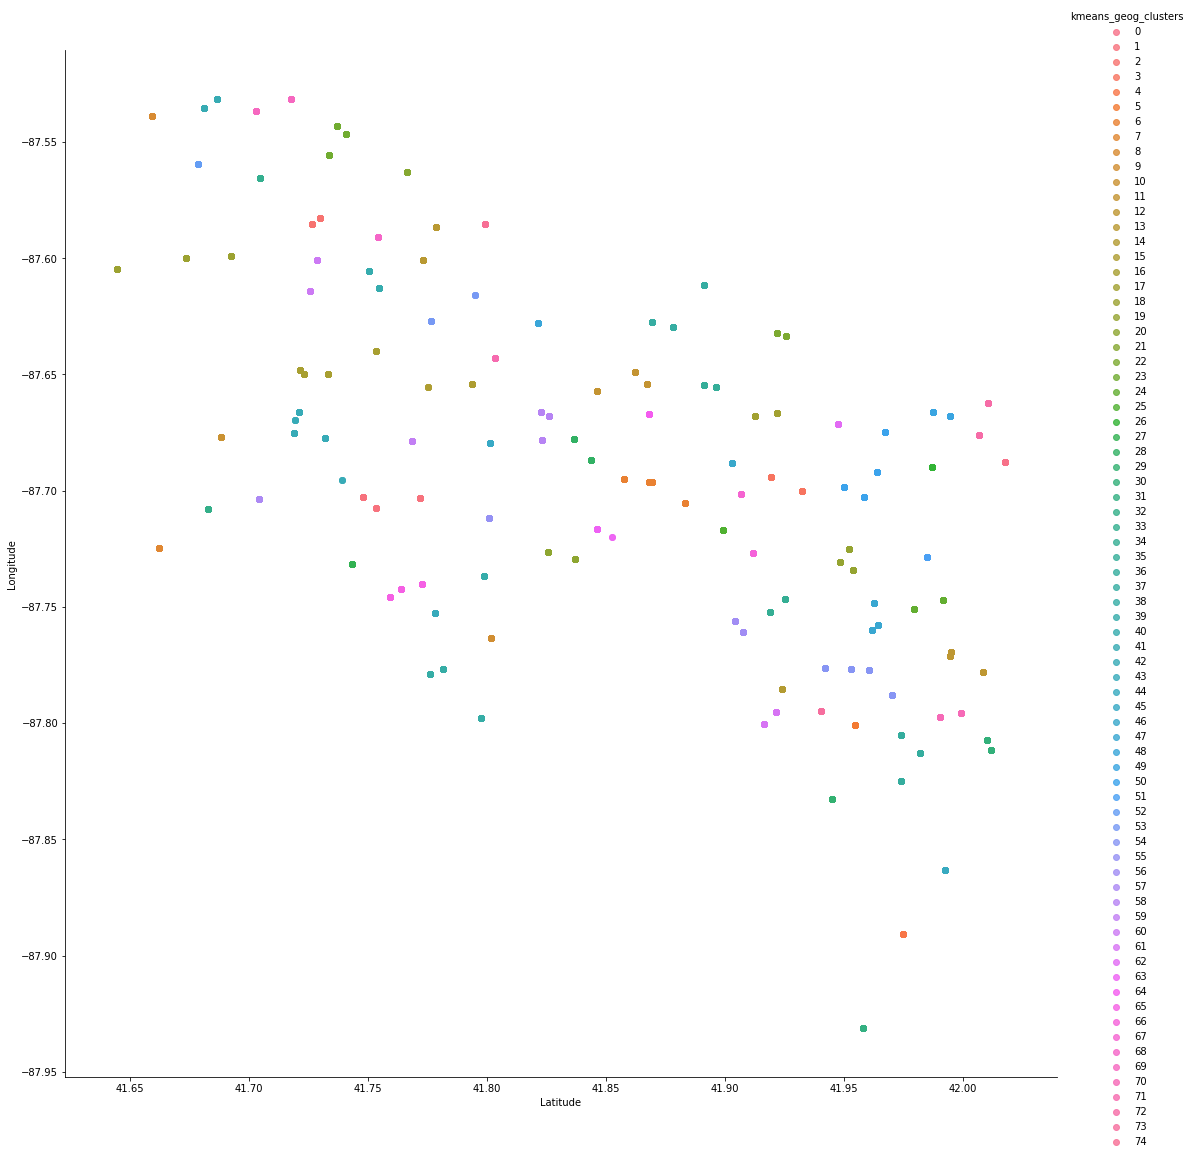

In [10]:
df_clusters = geo_cluster_model(KMeans(n_clusters = 75), 'kmeans_geog', df_combined,
                 features = ['Latitude', 'Longitude'])
df_clusters.reset_index()

Number of classes: 75
Silhouette Score: 0.7479564909134355


NumMosquitos       WnvPresent      
                             mean count       mean count
kmeans_mosq_clusters                                    
0                       20.483607   122   0.122951   122
1                     1310.000000     1   1.000000     1
2                      266.400000     5   0.200000     5
3                        3.000000   801   0.014981   801
4                     2356.000000     1   1.000000     1
5                      821.000000     1   1.000000     1
6                       57.560000    25   0.200000    25
7                      156.000000     8   0.125000     8
8                      467.000000     1   0.000000     1
9                     1653.000000     2   1.000000     2
10                     105.312500    16   0.437500    16
11                     968.000000     1   1.000000     1
12                     647.500000     2   1.000000     2
13                       8.495192   416   0.060096   416
14                      35.760417    96   0.177083    96
15                     391.666667     3   0.333333     3
16                    1548.500000     2   0.500000     2
17                     181.166667     6   0.666667     6
18                     232.833333     6   0.333333     6
19                      79.142857    21   0.238095    21
20                    2532.000000     1   1.000000     1
21                     127.750000    16   0.312500    16
22                    2207.000000     1   1.000000     1
23                     306.777778     9   0.444444     9
24                       1.000000  2096   0.008111  2096
25                      15.522613   199   0.110553   199
26                     527.000000     1   1.000000     1
27                      53.540000    50   0.200000    50
28                      23.048951   143   0.139860   143
29                    1054.000000     1   1.000000     1
...                           ...   ...        ...   ...
45                      10.452308   325   0.055385   325
46                       2.000000  1167   0.005141  1167
47                     561.000000     1   1.000000     1
48                     115.944444    18   0.166667    18
49                    1000.000000     1   1.000000     1
50                     196.000000     8   0.125000     8
51                     362.000000     1   0.000000     1
52                     169.666667     6   0.166667     6
53                     502.000000     1   0.000000     1
54                      26.009615   104   0.125000   104
55                       4.000000   539   0.022263   539
56                     280.000000     3   1.000000     3
57                    1520.000000     1   0.000000     1
58                      31.884058    69   0.173913    69
59                      62.350000    40   0.250000    40
60                      98.062500    16   0.125000    16
61                     290.000000     3   0.666667     3
62                       6.000000   365   0.027397   365
63                      17.946860   207   0.091787   207
64                     146.571429     7   0.142857     7
65                       7.000000   302   0.029801   302
66                      74.500000    20   0.250000    20
67                     479.000000     2   0.000000     2
68                      50.026316    38   0.105263    38
69                     219.714286     7   0.428571     7
70                      85.523810    21   0.190476    21
71                     984.000000     1   1.000000     1
72                      42.891304    46   0.152174    46
73                     836.000000     1   0.000000     1
74                     376.000000     2   0.500000     2

[75 rows x 4 columns]

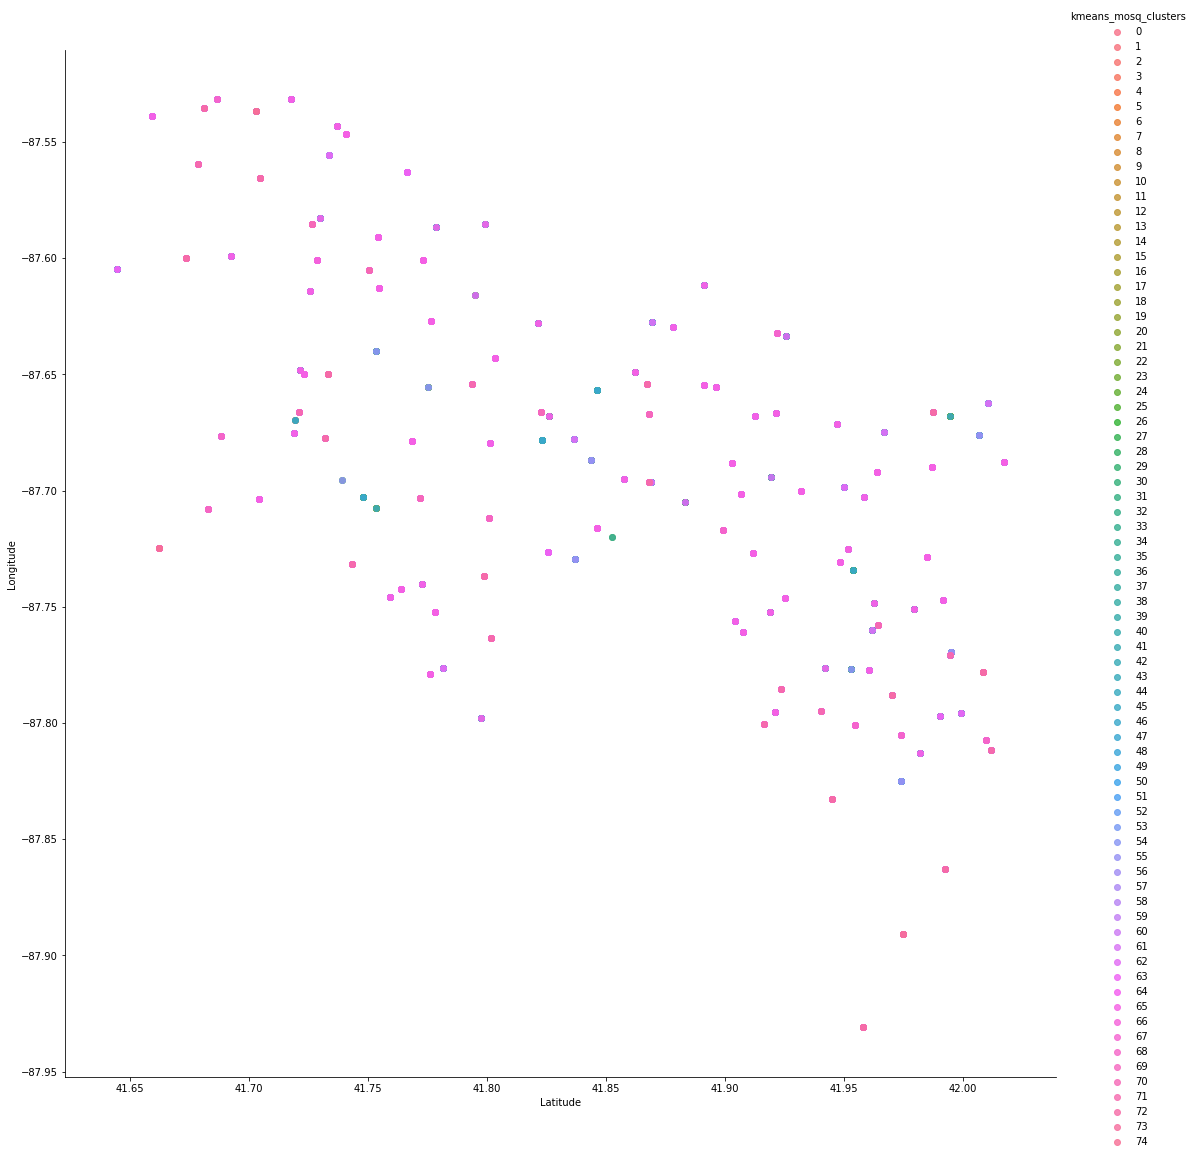

In [11]:
geo_cluster_model(KMeans(n_clusters = 75), 'kmeans_mosq', df_combined,
                 features = ['Latitude', 'Longitude', 'NumMosquitos'])

Number of classes: 2
Silhouette Score: 0.8368148608943343


NumMosquitos       WnvPresent      
                               mean count       mean count
meanshift_wnv_clusters                                    
0                         11.779557  7993          0  7993
1                         89.376368   457          1   457

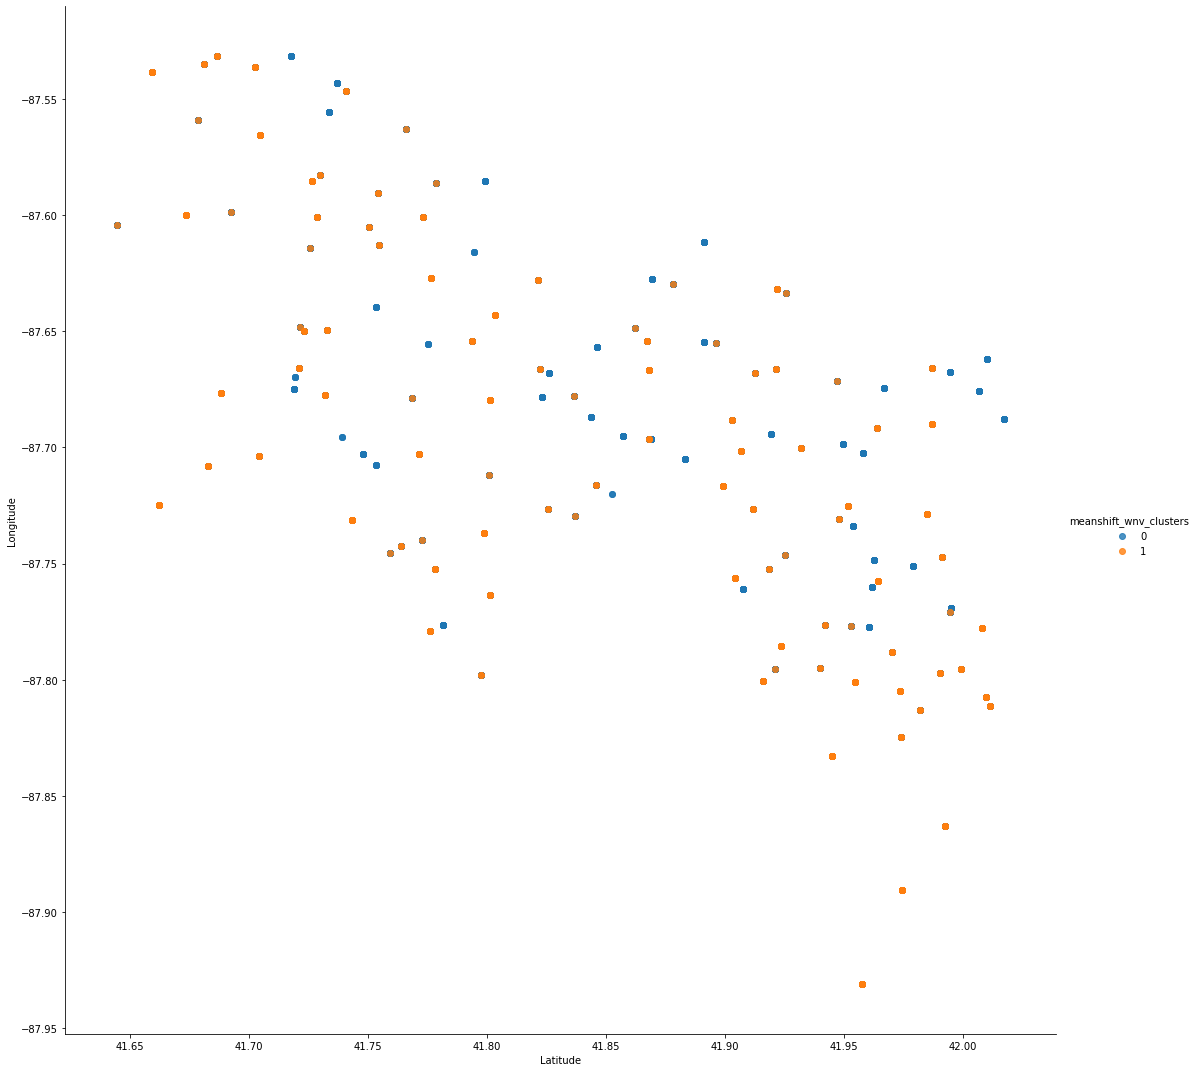

In [13]:
geo_cluster_model(MeanShift(cluster_all = True, n_jobs = -1), 'meanshift_wnv', df_combined,
                features = ['Latitude', 'Longitude', 'WnvPresent'])

Number of classes: 36
Silhouette Score: 0.8341118495663251


NumMosquitos       WnvPresent      
                                mean count       mean count
meanshift_mosq_clusters                                    
0                           7.911300  8106   0.043548  8106
1                          82.975124   201   0.248756   201
2                         135.142857    28   0.250000    28
3                         216.076923    13   0.538462    13
4                         158.500000    14   0.214286    14
5                         179.125000     8   0.500000     8
6                         238.727273    11   0.181818    11
7                         197.111111     9   0.111111     9
8                         305.300000    10   0.500000    10
9                         261.166667     6   0.166667     6
10                        281.666667     6   0.666667     6
11                        371.333333     3   0.333333     3
12                        416.666667     3   0.333333     3
13                        335.333333     3   0.000000     3
14                        475.000000     3   0.000000     3
15                        391.666667     3   0.333333     3
16                       1653.000000     2   1.000000     2
17                        647.500000     2   1.000000     2
18                       1548.500000     2   0.500000     2
19                       1520.000000     1   0.000000     1
20                        984.000000     1   1.000000     1
21                        836.000000     1   0.000000     1
22                       1054.000000     1   1.000000     1
23                       1000.000000     1   1.000000     1
24                        712.000000     1   1.000000     1
25                        561.000000     1   1.000000     1
26                        502.000000     1   0.000000     1
27                        821.000000     1   1.000000     1
28                       2532.000000     1   1.000000     1
29                       2356.000000     1   1.000000     1
30                       2207.000000     1   1.000000     1
31                       1310.000000     1   1.000000     1
32                        968.000000     1   1.000000     1
33                        914.000000     1   0.000000     1
34                        765.000000     1   0.000000     1
35                        527.000000     1   1.000000     1

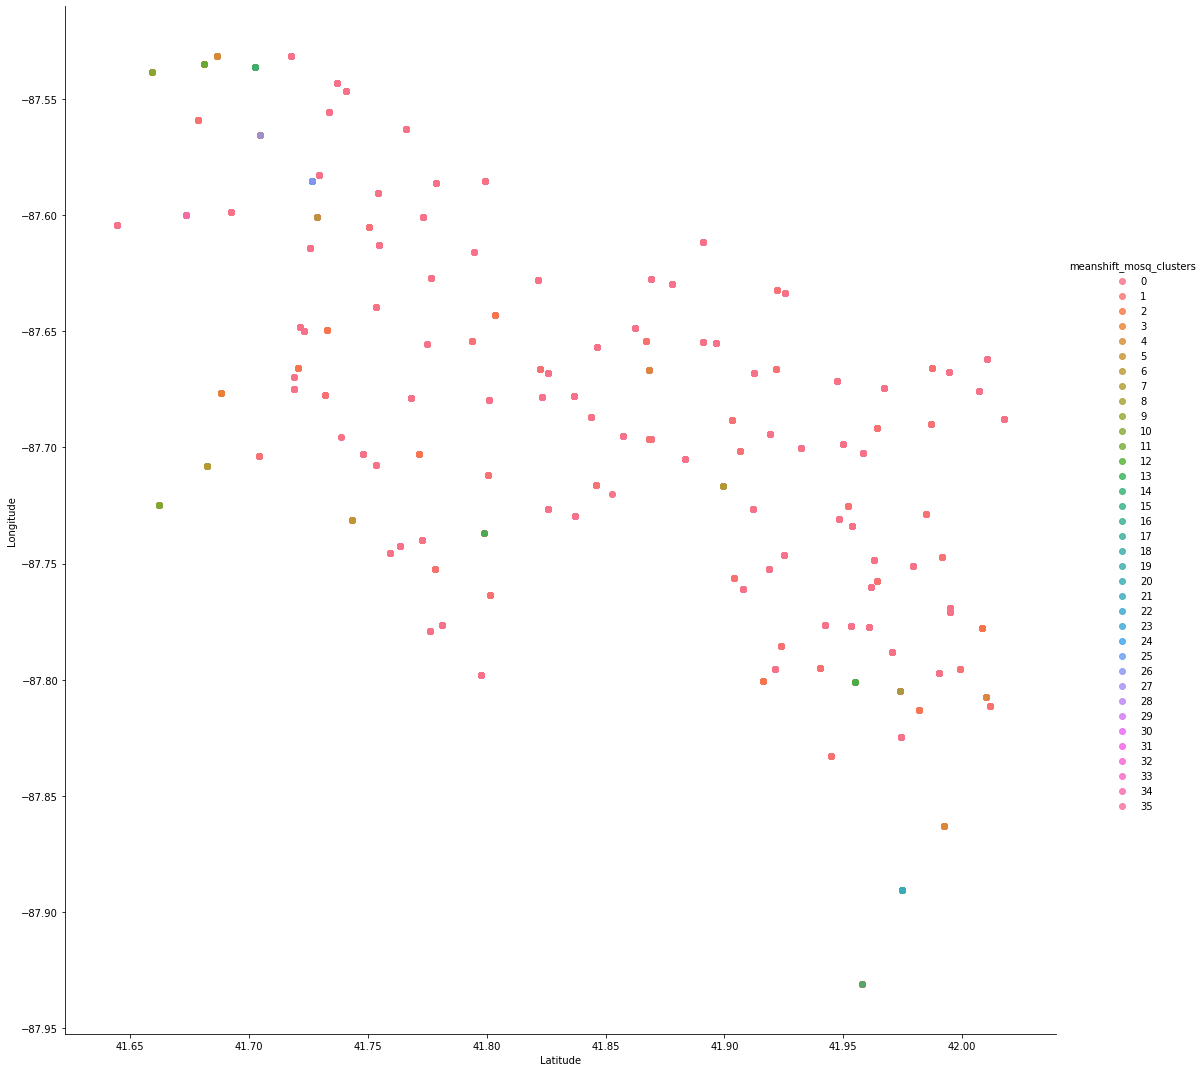

In [14]:
geo_cluster_model(MeanShift(cluster_all = True, n_jobs = -1), 'meanshift_mosq', df_combined,
                 features = ['Latitude', 'Longitude', 'NumMosquitos'])

## 3. Customized Train Test Splits (By Year, Target)

In [160]:
'''
This function fits a KNN to the train set, and predicts it on the test (kaggle) set with n_neighbors = 1 and weights
set to distance to attach the point to its nearest neighbor.

The if functions differentiates between clustering with NumMosquitos as a feature, and clustering without NumMosquitos.
The key word 'mosq' must be in the cluster name for the function to work.
'''



def classify_clusters(df_main, df_class, clusters):
    df_test_clf = df_class
    knn = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
    
    for cluster in clusters:
        #Include num mosquitos in clustering
        if 'mosq' in cluster:
            knn.fit(df_main[['Latitude', 'Longitude', 'NumMosquitos']], df_main[cluster])
            geo_clusters = knn.predict(df_class[['Latitude', 'Longitude', 'NumMosquitos']])
            df_test_clf[cluster] = geo_clusters
            
        #Exclude num mosquitos in clustering (lat long only)
        else:
            knn.fit(df_main[['Latitude', 'Longitude']], df_main[cluster])
            geo_clusters = knn.predict(df_class[['Latitude', 'Longitude']])
            df_test_clf[cluster] = geo_clusters        
    
    return df_test_clf

In [161]:
'''
This function does the following:
1) Loops through a dictionary to find what variations of the train test split should be made. 
Refer to X_dict for an example.

2) Call the classify_clusters function to find class labels on the test/kaggle set

3) Gets dummies based on a specified feature list (this is to enable quick dropping of features while modelling)

4) Runs a try/except to drop all unwanted features based on a feature list (to enable quick feature selection)

5) Checks if the train set and kaggle set features tally, and adds empty columns or drops columns in the kaggle set
if needed.

6) Rearranges the column order so the train and kaggle data sets are aligned (since XGBoost gets cranky otherwise)

'''

def split_datasets(X, y, Xtrain, ytrain, Xtest, ytest, metadict, dummy_features, features_to_drop, clusters = None):
    
    #Loop through dictionary to get dataframe variations
    #Also gets dummies based on dummy_features list
    for i in X.keys():
        
        #Drop clusters from unwanted features list
        #Predicts clusters in kaggle set if clusters is not none
        if clusters != None:
            unwanted_features = [item for item in features_to_drop if item not in clusters]
            metadict[i] = classify_clusters(df_combined, df_kag, clusters)
        else:
            unwanted_features = features_to_drop
        
        try: #If we can stratify y (i.e. binary task)
            Xtrain[i], Xtest[i], ytrain[i], ytest[i] = train_test_split(
                pd.get_dummies(X[i], columns = dummy_features), y[i], test_size = 0.3, stratify = y[i])
            
        except: #Can't stratify y (i.e. regression task, too few values of y)
            print('Could not stratify y!')
            Xtrain[i], Xtest[i], ytrain[i], ytest[i] = train_test_split(
                pd.get_dummies(X[i], columns = dummy_features), y[i], test_size = 0.3)    
        
        #Create a new meta test set (the kaggle set) with features that correspond to train
        #Gets dummies, and drops the Id column which doesn't exist in the train set
        metadict[i] = df_kag
        metadict[i] = pd.get_dummies(metadict[i], columns = dummy_features)
        metadict[i].drop('Id', axis = 1, inplace = True)
        
        #Tries to drop features in unwanted_features list if it's there
        for feature in unwanted_features:
            try:
                Xtrain[i].drop(feature, axis = 1, inplace = True)
                Xtest[i].drop(feature, axis = 1, inplace = True)
            except:
                print('{} could not be dropped from X because it doesn\'t exist!'.format(feature))
                
            try:
                metadict[i].drop(feature, axis = 1, inplace = True)
            except:
                print('{} could not be dropped from metadict because it doesn\'t exist!'.format(feature))                
                               

        #Check if features tally
        to_remove = [col for col in metadict[i].columns if col not in Xtrain[i].columns]
        to_add = [col for col in Xtrain[i].columns if col not in metadict[i].columns]
        print('{} removed from meta dataframe {}'.format(to_remove, i))
        print('{} added to meta dataframe {}'.format(to_add, i))
        
        #If there are features that don't match, add or remove them.
        if to_remove != []:
            for remove in to_remove:
                metadict[i].drop(remove, axis = 1, inplace = True)

        if to_add != []:
            for add in to_add:
                metadict[i][add] = 0
                
        #Set order of columns to be equal
        metadict[i] = metadict[i][list(Xtrain[i].columns)]

In [117]:
'mosq' in 'dbscan_mosq_clusters'

True

In [135]:
#Finds true positive rate
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

In [145]:
#This monstrosity performs a grid search given a specified model and vectorizer, scores it on train/test sets,
#It then returns the test score (accuracy), AUC score, confusion matrix, the ROC/AUC curve, and a dataframe of features vs coefs
#IMPORTANT: what you call the model matters - use 'dt' for decision tree, 'svm' for SVM. 
#There's a better way to improve on this - maybe in the future.

def grid_fit(X, y, Xt, yt, model, pipe_params, scale = 'N', name = 'submission', fit_kag = '-', optimize_on = 'roc_auc'):
    sc = StandardScaler()
    kf = KFold(n_splits=3)

    if scale == 'Y':
        X = sc.fit_transform(X)
        Xt = sc.transform(Xt)
        
    #Fit gridsearch to train set   
    gs = GridSearchCV(model, param_grid=pipe_params, cv=3, scoring = optimize_on, n_jobs = -1, verbose = 10)
    gs.fit(X, y)
    
    #Score on test set and print both train/test scores
    test_score = gs.score(Xt, yt)
    print('Train Score: {}'.format(gs.best_score_))
    print('Test Score: {}'.format(test_score))
    
    #Generate Confusion Matrix
    predictions = gs.predict(Xt)
    tn, fp, fn, tp = confusion_matrix(yt, predictions).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print(gs.best_params_)
    
        
    
    #Generate AUC ROC curve
    #Generate dataframe mapping true values to pred probs
    pred_proba = [i[1] for i in gs.predict_proba(Xt)]

    pred_df = pd.DataFrame({'true_values': yt,
                        'pred_probs':pred_proba})
    
    #Try to get coeffs:
    try:
        coefs_with_fns = sorted(zip(gs.best_estimator_.feature_importances_, X.columns))
        coefs_with_fns = pd.DataFrame(coefs_with_fns, columns = ['coef', 'feature'])
    
    except:
        try:
            feature_names = gs.best_estimator_.get_feature_names()
            coefs_with_fns = sorted(zip(gs.best_estimator_.coef_[0], feature_names))
            coefs_with_fns = pd.DataFrame(coefs_with_fns, columns = ['coef', 'feature'])
        except:
            coefs_with_fns = 'No features generated'
    
    # Create figure.
    plt.figure(figsize = (10,7))

    # Create threshold values.
    thresholds = np.linspace(0, 1, 200)

    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    
    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve', color = 'g')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')
    
    #plots lines to connect graph to origin and 1,1 - the graph appears awkward otherwise.
    plt.plot((0, 0), (0, tpr_values[len(tpr_values)-1]), color = 'g')
    plt.plot((fpr_values[0], 1), (1 , 1), color = 'g')
    
    #Calculate AUC score to output in 'return' tuple and print on graph
    auc_score = round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)
    
    # Label axes.
    plt.title(f'ROC Curve with AUC = {auc_score}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)
    
    if isinstance(fit_kag, pd.DataFrame): #Generate kaggle submission if fit_kag = true
    
        pred_kag = [i[1] for i in gs.predict_proba(fit_kag)]
        sub_df = pd.DataFrame(list(pred_kag), index = df_kag['Id'], columns = ['WnvPresent'])
        sub_df.to_csv(name+".csv")

    # Create legend.
    plt.legend(fontsize=16);
    return (gs.best_params_ , auc_score, pred_proba, pred_kag, coefs_with_fns)

In [20]:
#Review columns
df_combined.columns

Index(['Unnamed: 0', 'Date', 'Trap', 'Latitude', 'Longitude', 'Season', 'Year',
       'Month', 'NumMosquitos', 'WnvPresent', 'Tavg_x', 'PrecipTotal_x',
       'is_sprayed', 'Station', 'Tavg_y', 'Depart', 'WetBulb', 'Heat', 'Cool',
       'PrecipTotal_y', 'AvgSpeed', 'TS', 'RA', 'DZ', 'BR', 'HZ', 'humidity',
       'Temp_diff', 'daylight_hours', 'past_week_tavg', 'past_week_precip',
       'past_week_humid', 'past_mth_tavg', 'past_mth_precip', 'past_mth_humid',
       'rained_last_week', 'past_3_tavg', 'past_3_precip', 'past_3_humid',
       'past_3_wind', 'distance_to_T900', 'distance_to_T002',
       'distance_to_T008', 'distance_to_T115', 'distance_to_T090',
       'distance_to_T095', 'distance_to_T158', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX',
       'dbscan_geog_clusters', 'dbscan_mosq_clusters', 'kmeans_geog_cluste

In [40]:
# Dictionaries for creating different datasets in Train Test Split
#For WNV
X_dict = {
    0: df_combined,
    1: df_combined[df_combined['Year']==2007],
    2: df_combined[df_combined['Year']==2009],
    3: df_combined[df_combined['Year']==2011],
    4: df_combined[df_combined['Year']==2013]
    
}

#For WNV
y_dict = {
    0: df_combined['WnvPresent'],
    1: df_combined[df_combined['Year']==2007]['WnvPresent'],
    2: df_combined[df_combined['Year']==2009]['WnvPresent'],
    3: df_combined[df_combined['Year']==2011]['WnvPresent'],
    4: df_combined[df_combined['Year']==2013]['WnvPresent']
    
}
#For NumMosq
Xmosq_dict = {
    0: df_combined,
    1: df_combined[df_combined['Year']==2007],
    2: df_combined[df_combined['Year']==2009],
    3: df_combined[df_combined['Year']==2011],
    4: df_combined[df_combined['Year']==2013]
    
}
#For NumMosq
ymosq_dict = {
    0: df_combined['NumMosquitos'],
    1: df_combined[df_combined['Year']==2007]['NumMosquitos'],
    2: df_combined[df_combined['Year']==2009]['NumMosquitos'],
    3: df_combined[df_combined['Year']==2011]['NumMosquitos'],
    4: df_combined[df_combined['Year']==2013]['NumMosquitos']
    
}

In [126]:
# Test Train Splits by Year

features_to_drop =['WnvPresent', 'NumMosquitos', 'is_sprayed', 'Season','Month', 'WetBulb', 'Date', 'Trap', 'Latitude', 
                   'Longitude', 'kmeans_geog_clusters', 'Year', 'Station', 'kmeans_mosq_clusters', 
                   'dbscan_geog_clusters', 'dbscan_mosq_clusters', 'meanshift_wnv_clusters', 'meanshift_mosq_clusters']
#clusters must be a list
clusters = ['dbscan_mosq_clusters']
#dummy_features must be a list    
dummy_features =  ['dbscan_mosq_clusters']



meta_dict = {}

X_train = {}
y_train = {}
X_test = {}
y_test = {}

split_datasets(X_dict, y_dict, X_train, y_train, X_test, y_test, meta_dict, dummy_features,
               features_to_drop, clusters = clusters)

WnvPresent could not be dropped from metadict because it doesn't exist!
kmeans_mosq_clusters could not be dropped from metadict because it doesn't exist!
dbscan_geog_clusters could not be dropped from metadict because it doesn't exist!
meanshift_wnv_clusters could not be dropped from metadict because it doesn't exist!
meanshift_mosq_clusters could not be dropped from metadict because it doesn't exist!
[] removed from meta dataframe 0
[] added to meta dataframe 0
WnvPresent could not be dropped from metadict because it doesn't exist!
kmeans_mosq_clusters could not be dropped from metadict because it doesn't exist!
dbscan_geog_clusters could not be dropped from metadict because it doesn't exist!
meanshift_wnv_clusters could not be dropped from metadict because it doesn't exist!
meanshift_mosq_clusters could not be dropped from metadict because it doesn't exist!
['dbscan_mosq_clusters_62', 'dbscan_mosq_clusters_64'] removed from meta dataframe 1
[] added to meta dataframe 1
WnvPresent cou

In [103]:
#To predict mosquitos
features_to_drop =['WnvPresent', 'NumMosquitos', 'is_sprayed', 'Season','Month', 'WetBulb', 'Date', 'Trap', 'Latitude', 
                   'Longitude', 'kmeans_geog_clusters', 'Year', 'Station', 'kmeans_mosq_clusters', 'Tavg_x', 'PrecipTotal_x',
                   'dbscan_geog_clusters', 'dbscan_mosq_clusters', 'meanshift_wnv_clusters', 'meanshift_mosq_clusters']


clusters = None
    
dummy_features =  []

metamosq_dict = {}

Xmosq_train = {}
ymosq_train = {}
Xmosq_test = {}
ymosq_test = {}

split_datasets(Xmosq_dict, ymosq_dict, Xmosq_train, ymosq_train, Xmosq_test, ymosq_test, metamosq_dict, dummy_features,
               features_to_drop, clusters = clusters)

Could not stratify y!
WnvPresent could not be dropped from metadict because it doesn't exist!
NumMosquitos could not be dropped from metadict because it doesn't exist!
kmeans_mosq_clusters could not be dropped from metadict because it doesn't exist!
dbscan_geog_clusters could not be dropped from metadict because it doesn't exist!
dbscan_mosq_clusters could not be dropped from metadict because it doesn't exist!
meanshift_wnv_clusters could not be dropped from metadict because it doesn't exist!
meanshift_mosq_clusters could not be dropped from metadict because it doesn't exist!
[] removed from meta dataframe 0
[] added to meta dataframe 0
Could not stratify y!
WnvPresent could not be dropped from metadict because it doesn't exist!
NumMosquitos could not be dropped from metadict because it doesn't exist!
kmeans_mosq_clusters could not be dropped from metadict because it doesn't exist!
dbscan_geog_clusters could not be dropped from metadict because it doesn't exist!
dbscan_mosq_clusters co

## 4. Modelling

In [159]:
def predict_mosquitos(Xtrain, ytrain, Xtest, ytest):
    parameters_for_testing = {
        'colsample_bytree':[0.8, 0.9],
        'learning_rate':[0.1],
        'max_depth':[6,7,8],
        'n_estimators':[750, 500, 1000, 1250],
        'reg_alpha': [0.5],
        'objective' : ['reg:gamma']
    }

    xgb_model = XGBRegressor(min_child_weight=1, n_jobs = -1, verbose = 10)

    #Set verbose = 0 to disable xgboost from talking dirty
    gs = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=-1, iid=True, verbose=10, 
                      scoring='r2', cv = 3)
    
    gs.fit(Xtrain, ytrain)

    print('Settings for XGBRegressor: {}'.format(gs.best_estimator_))
    print('Score for XGBRegressor: {}'.format(gs.score(Xtest, ytest)))

    mosq_predictions = gs.predict(metamosq_dict[0])
    df_kag['NumMosquitos'] = mosq_predictions
    return mosq_predictions

The r2 here varies greatly depending on the run - as low as 0.25 to 0.55 depending on the train test split and randomness (since no random seed was specified). This, in turns, affects subsequent predictions. This model has returned kaggle scores ranging from 0.65 to 0.79, but the variability of this method means that it is highly undesirable in a production setting. The final prediction is based on three models - the unsupervised learning from the DBScan (which has some randomness to it), the regression predicting NumMosquitos (which ALSO has randomness to it), and the final classifier. This is basically playing the lottery.

If there's one way to greatly improve this model, it would be to further tune the hyperparameters for the XGBregressor or to make better predictions for NumMosquitos

<p style="color:red"><b>Warning - the grid searches below will take awhile (roughly 10 minutes per model) to run.</b></p>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:  1.4min remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:  1.5min remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.5min finished
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Settings for XGBRegressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=10, verbosity=1)
Score for XGBRegressor: 0.23982513888710888
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8

Train Score: 0.8863788921210791
Test Score: 0.8987994861898297
True Negatives: 2379
False Positives: 19
False Negatives: 116
True Positives: 21
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 750, 'objective': 'binary:logistic'}


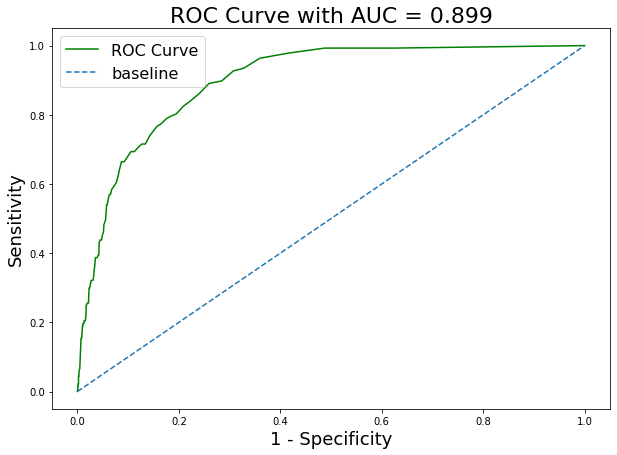

In [154]:
#Predict mosquitos
predict_mosquitos(Xmosq_train[0], ymosq_train[0], Xmosq_test[0], ymosq_test[0])

#Classify
xgb = XGBClassifier(n_jobs = -1, verbose=10)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [2,3,4,5],
              'min_child_weight': [1],
              'colsample_bytree': [0.5, 0.6, 0.8],
              'n_estimators': [750, 1000, 1250, 1500, 1750]}


xgb_combined = grid_fit(X_train[0], y_train[0], X_test[0], y_test[0], model = xgb, pipe_params = parameters,
         fit_kag = meta_dict[0], optimize_on = 'roc_auc', name = 'xgb_kag')

In [24]:
X_train[0].columns

Index(['Season', 'Tavg_x', 'PrecipTotal_x', 'Tavg_y', 'Depart', 'Heat', 'Cool',
       'PrecipTotal_y', 'AvgSpeed', 'TS', 'RA', 'DZ', 'BR', 'HZ', 'humidity',
       'Temp_diff', 'daylight_hours', 'past_week_tavg', 'past_week_precip',
       'past_week_humid', 'past_mth_tavg', 'past_mth_precip', 'past_mth_humid',
       'rained_last_week', 'past_3_tavg', 'past_3_precip', 'past_3_humid',
       'past_3_wind', 'distance_to_T900', 'distance_to_T002',
       'distance_to_T008', 'distance_to_T115', 'distance_to_T090',
       'distance_to_T095', 'distance_to_T158', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX'],
      dtype='object')

In [26]:
meta_dict[0].columns

Index(['Season', 'Tavg_x', 'PrecipTotal_x', 'Tavg_y', 'Depart', 'Heat', 'Cool',
       'PrecipTotal_y', 'AvgSpeed', 'TS', 'RA', 'DZ', 'BR', 'HZ', 'humidity',
       'Temp_diff', 'daylight_hours', 'past_week_tavg', 'past_week_precip',
       'past_week_humid', 'past_mth_tavg', 'past_mth_precip', 'past_mth_humid',
       'rained_last_week', 'past_3_tavg', 'past_3_precip', 'past_3_humid',
       'past_3_wind', 'distance_to_T900', 'distance_to_T002',
       'distance_to_T008', 'distance_to_T115', 'distance_to_T090',
       'distance_to_T095', 'distance_to_T158', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX'],
      dtype='object')

In [98]:
df_combined.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'Season', 'Year', 'Month',
       'NumMosquitos', 'WnvPresent', 'Tavg_x', 'PrecipTotal_x', 'is_sprayed',
       'Station', 'Tavg_y', 'Depart', 'WetBulb', 'Heat', 'Cool',
       'PrecipTotal_y', 'AvgSpeed', 'TS', 'RA', 'DZ', 'BR', 'HZ', 'humidity',
       'Temp_diff', 'daylight_hours', 'past_week_tavg', 'past_week_precip',
       'past_week_humid', 'past_mth_tavg', 'past_mth_precip', 'past_mth_humid',
       'rained_last_week', 'past_3_tavg', 'past_3_precip', 'past_3_humid',
       'past_3_wind', 'distance_to_T900', 'distance_to_T002',
       'distance_to_T008', 'distance_to_T115', 'distance_to_T090',
       'distance_to_T095', 'distance_to_T158', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX',
       'dbscan_geog_clusters', 'dbscan_mosq_clusters', 'kmeans_geog_clusters',
       'k

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:   27.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:   30.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   30.9s finished
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Settings for XGBRegressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=750,
             n_jobs=-1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=10, verbosity=1)
Score for XGBRegressor: 0.15169457251124707
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3

Train Score: 0.8677808298784724
Test Score: 0.8926352339181286
True Negatives: 758
False Positives: 10
False Negatives: 42
True Positives: 15
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 750, 'objective': 'binary:logistic'}


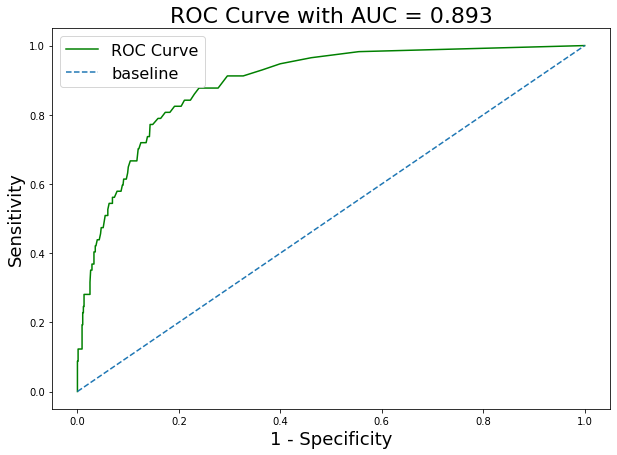

In [155]:
#Predict mosquitos
predict_mosquitos(Xmosq_train[1], ymosq_train[1], Xmosq_test[1], ymosq_test[1])


#Fit Model on 2007 ONLY
xgb = XGBClassifier(n_jobs = -1, verbose=10)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [2,3,4,5],
              'min_child_weight': [1],
              'colsample_bytree': [0.5, 0.6, 0.8],
              'n_estimators': [750, 1000, 1250, 1500, 1750]}


xgb_2007 = grid_fit(X_train[1], y_train[1], X_test[1], y_test[1], model = xgb, pipe_params = parameters,
         fit_kag = meta_dict[1], optimize_on = 'roc_auc', name = 'xgb_kag2007')

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:   17.9s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:   19.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.3s finished
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Settings for XGBRegressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=750,
             n_jobs=-1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=10, verbosity=1)
Score for XGBRegressor: 0.484763649373529
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2

Train Score: 0.8736700211647198
Test Score: 0.6794083186877563
True Negatives: 567
False Positives: 2
False Negatives: 5
True Positives: 1
{'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1250, 'objective': 'binary:logistic'}


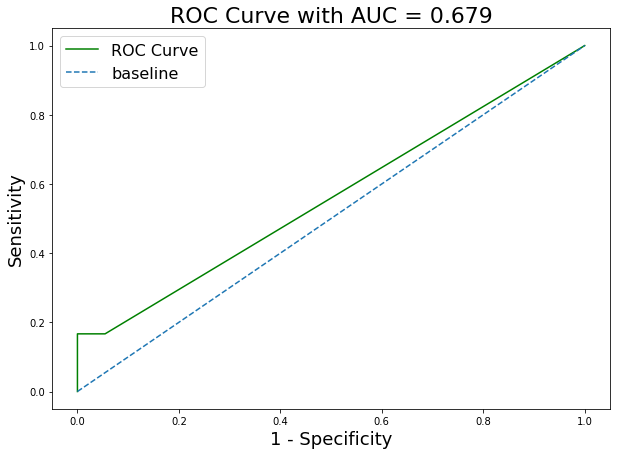

In [156]:
#Predict mosquitos
predict_mosquitos(Xmosq_train[2], ymosq_train[2], Xmosq_test[2], ymosq_test[2])

#Fit Model on 2009 ONLY
xgb = XGBClassifier(n_jobs = -1, verbose=10)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [2,3,4,5],
              'min_child_weight': [1],
              'colsample_bytree': [0.5, 0.6, 0.8],
              'n_estimators': [750, 1000, 1250, 1500, 1750]}


xgb_2009 = grid_fit(X_train[2], y_train[2], X_test[2], y_test[2], model = xgb, pipe_params = parameters,
         fit_kag = meta_dict[2], optimize_on = 'roc_auc', name = 'xgb_kag2009')

The model and features selected does poorly for the years with low WNV counts.

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:   26.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:   27.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   29.0s finished
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Settings for XGBRegressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=750,
             n_jobs=-1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=10, verbosity=1)
Score for XGBRegressor: 0.31300535849583644
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2

Train Score: 0.8269999901598155
Test Score: 0.9397807865892972
True Negatives: 517
False Positives: 0
False Negatives: 14
True Positives: 1
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 750, 'objective': 'binary:logistic'}


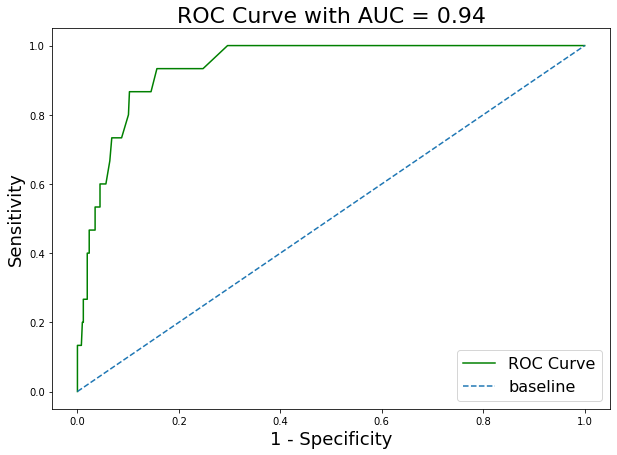

In [157]:
#Predict mosquitos
predict_mosquitos(Xmosq_train[3], ymosq_train[3], Xmosq_test[3], ymosq_test[3])

#Fit Model on 2011 ONLY
xgb = XGBClassifier(n_jobs = -1, verbose=10)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [2,3,4,5],
              'min_child_weight': [1],
              'colsample_bytree': [0.5, 0.6, 0.8],
              'n_estimators': [750, 1000, 1250, 1500, 1750]}


xgb_2011 = grid_fit(X_train[3], y_train[3], X_test[3], y_test[3], model = xgb, pipe_params = parameters,
         fit_kag = meta_dict[3], optimize_on = 'roc_auc', name = 'xgb_kag2011')

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:   26.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:   29.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   29.4s finished
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Settings for XGBRegressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=750,
             n_jobs=-1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=10, verbosity=1)
Score for XGBRegressor: 0.4719909598663372
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3

Train Score: 0.7808600466097141
Test Score: 0.8388786764705883
True Negatives: 535
False Positives: 9
False Negatives: 55
True Positives: 5
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 750, 'objective': 'binary:logistic'}


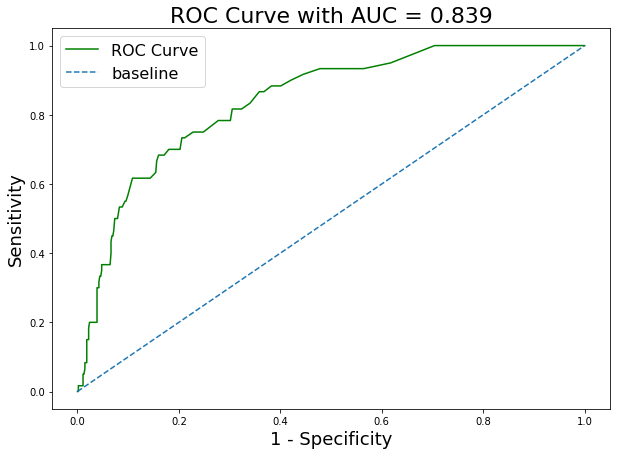

In [158]:
#Predict mosquitos
predict_mosquitos(Xmosq_train[4], ymosq_train[4], Xmosq_test[4], ymosq_test[4])

#Fit Model on 2013 ONLY
xgb = XGBClassifier(n_jobs = -1, verbose=10)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [2,3,4,5],
              'min_child_weight': [1],
              'colsample_bytree': [0.5, 0.6, 0.8],
              'n_estimators': [750, 1000, 1250, 1500, 1750]}


xgb_2013 = grid_fit(X_train[4], y_train[4], X_test[4], y_test[4], model = xgb, pipe_params = parameters,
         fit_kag = meta_dict[4], optimize_on = 'roc_auc', name = 'xgb_kag2013')

## 5. Feature Importance

In [179]:
pd.DataFrame([xgb_combined[4].sort_values(by='coef', ascending = False).reset_index()['feature'].head(10),
              xgb_2007[4].sort_values(by='coef', ascending = False).reset_index()['feature'].head(10),
             xgb_2009[4].sort_values(by='coef', ascending = False).reset_index()['feature'].head(10),
             xgb_2011[4].sort_values(by='coef', ascending = False).reset_index()['feature'].head(10),
             xgb_2013[4].sort_values(by='coef', ascending = False).reset_index()['feature'].head(10)],
            index = ['combined', '2007', '2009', '2011', '2013']).T

,combined,2007,2009,2011,2013
0,dbscan_mosq_clusters_-1,dbscan_mosq_clusters_-1,dbscan_mosq_clusters_-1,dbscan_mosq_clusters_38,BR
1,PrecipTotal_x,past_mth_tavg,dbscan_mosq_clusters_4,PrecipTotal_y,dbscan_mosq_clusters_-1
2,past_mth_tavg,past_mth_precip,Species_CULEX RESTUANS,past_mth_tavg,daylight_hours
3,daylight_hours,past_mth_humid,daylight_hours,daylight_hours,past_mth_precip
4,Species_CULEX PIPIENS,dbscan_mosq_clusters_1,Depart,dbscan_mosq_clusters_0,Species_CULEX PIPIENS
5,dbscan_mosq_clusters_1,distance_to_T900,RA,dbscan_mosq_clusters_1,dbscan_mosq_clusters_63
6,Cool,past_week_humid,dbscan_mosq_clusters_2,dbscan_mosq_clusters_-1,PrecipTotal_y
7,past_mth_humid,dbscan_mosq_clusters_0,Tavg_y,past_3_wind,HZ
8,dbscan_mosq_clusters_0,Species_CULEX PIPIENS,past_mth_humid,past_mth_humid,dbscan_mosq_clusters_17
9,Tavg_y,dbscan_mosq_clusters_15,dbscan_mosq_clusters_32,distance_to_T095,past_mth_tavg


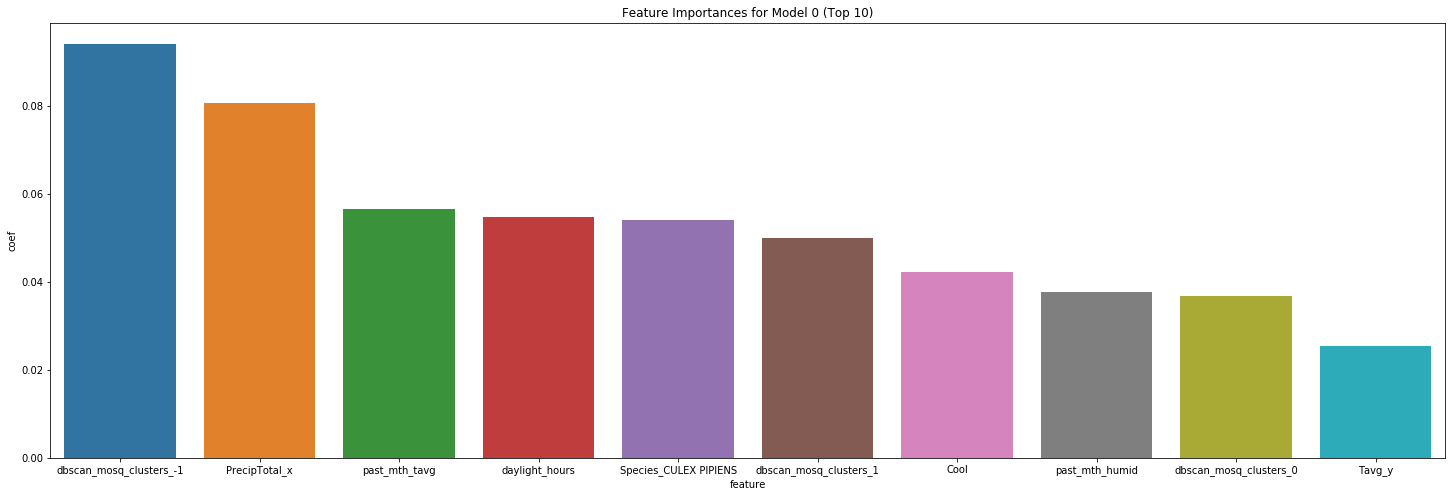

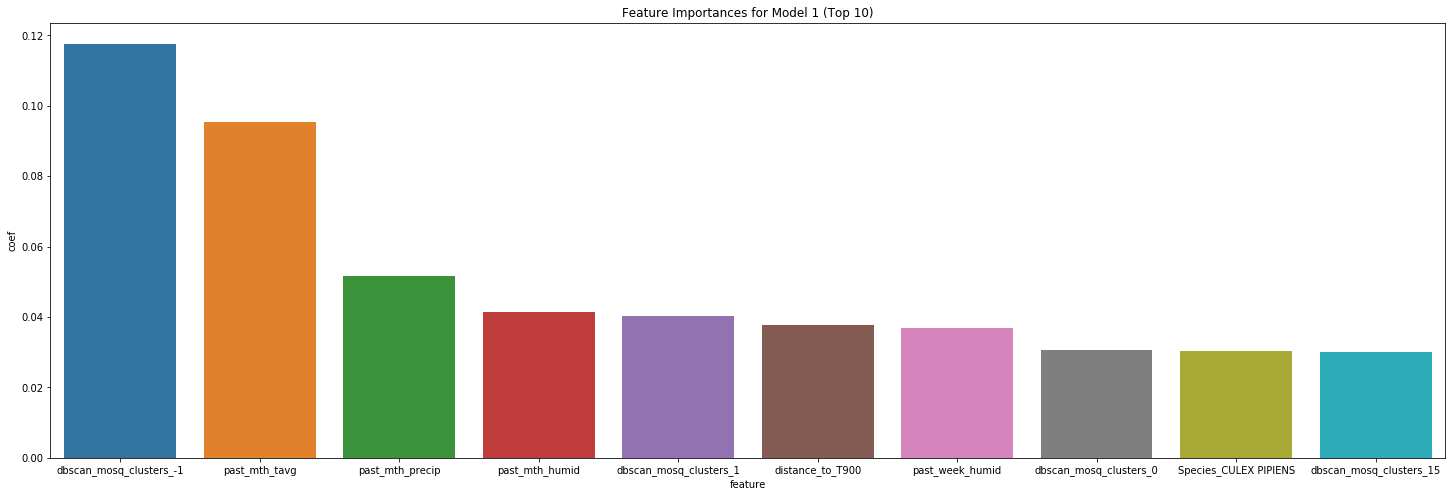

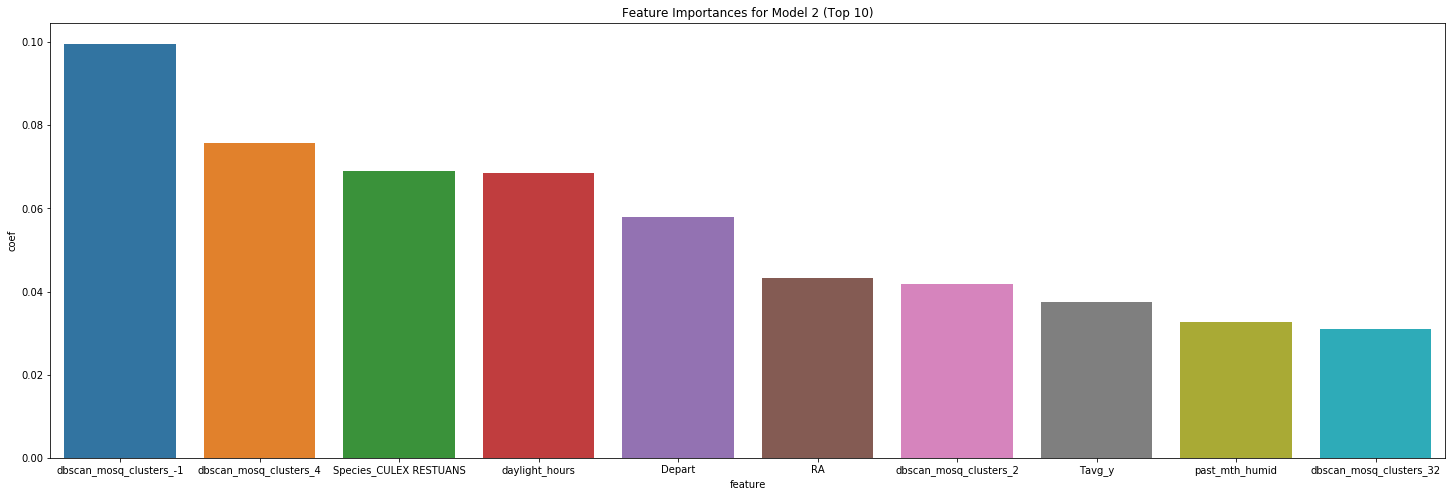

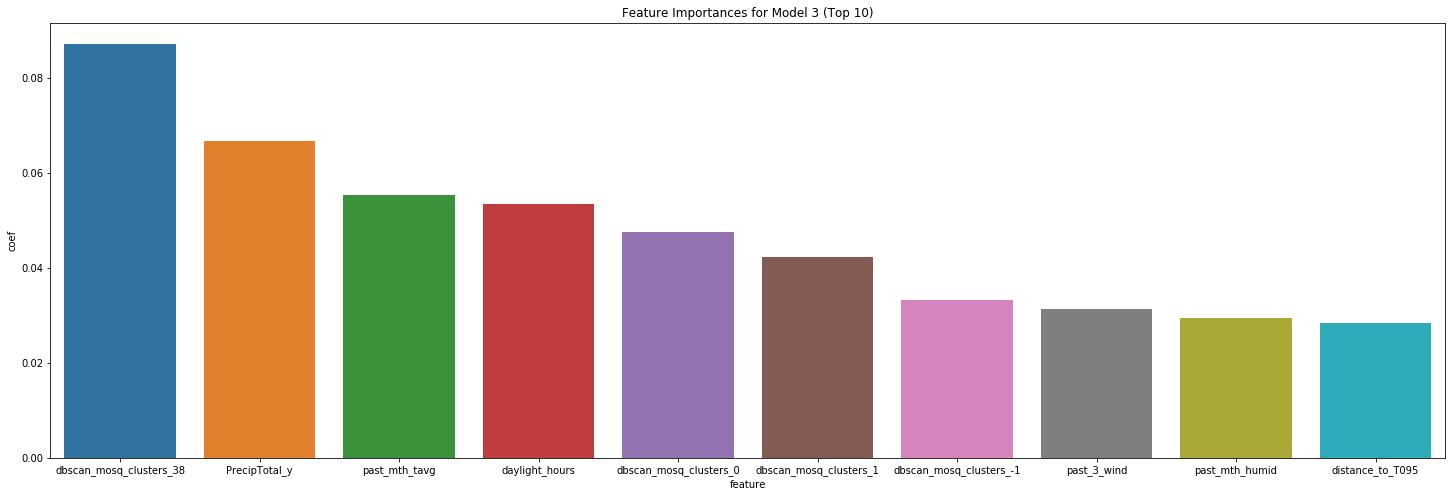

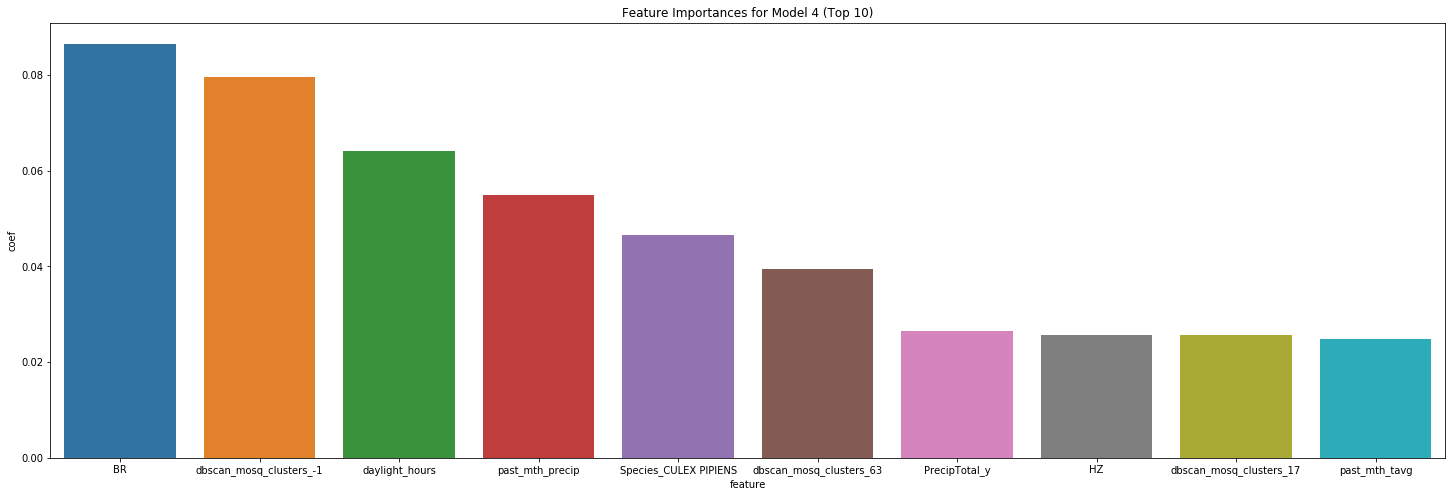

In [192]:
models = [xgb_combined, xgb_2007, xgb_2009, xgb_2011, xgb_2013]

for n, model in enumerate(models):
    plt.figure(figsize = (25,8))
    sns.barplot(x = 'feature', y = 'coef', data = model[4].sort_values(by='coef', ascending = False).head(10))
    plt.title('Feature Importances for Model {} (Top 10)'.format(n))

In [285]:
to_bag = pd.DataFrame([xgb_combined[3], xgb_2007[3], xgb_2009[3], xgb_2011[3], xgb_2013[3]], 
            index = ['combined', '2007', '2009', '2011', '2013']).T

In [286]:
#Changes index name to Id and shifts it down by 1 to align it with kaggle submission
to_bag.index.names = ['Id']
to_bag.index += 1

In [287]:
to_bag.head()

,combined,2007,2009,2011,2013
Id,,,,,
1,0.003977,0.037066,0.000736,0.003960,0.002595
2,0.003572,0.008647,0.001072,0.002338,0.001366
3,0.000964,0.047374,0.000538,0.000397,0.001437
4,0.001208,0.001759,0.000791,0.000176,0.000508
5,0.000549,0.001355,0.000791,0.000176,0.000508


In [288]:
#Calc geometric mean while taking into account overflow, just in case
def geo_mean_overflow(iterable):
    a = np.log(iterable)
    return np.exp(a.sum()/len(a))

In [289]:
to_bag['WnvPresent'] = to_bag.values.tolist()

In [261]:
to_bag['WnvPresent'] = to_bag['WnvPresent'].apply(lambda x: float(geo_mean_overflow(x)))

In [278]:
to_bag.drop(['combined', '2007', '2009', '2011', '2013'], axis = 1).to_csv('bagged_cart.csv')

## 6. Summary of Model

On the whole, this model performs poorly - the bagging strategy of combining multiple years proved to be a poor one as scores tended to be lower than simply the combined (all years) model. The last 3 all years model received scores of 0.69, 0.71, and 0.78 respectively depending on the tuning of hyperparameters. The bagged scores, on the other hand, received scores of 0.55, 0.6, and 0.61.

It was theorized that separating the train set into component years would be a viable modelling strategy, but it might have been better to use randomized samples for the bagging strategy instead.


Furthermore, this model is not viable in production due to it's long calculation times and variability in predicting results.